# Tutorial for regression

In this tutorial, we compare the prediction intervals estimated by MAPIE on a 
simple, one-dimensional, ground truth function

$$
f(x) = x \sin(x)
$$

Throughout this tutorial, we will answer the following questions:

- How well do the MAPIE strategies capture the aleatoric uncertainty existing in the data?

- How do the prediction intervals estimated by the resampling strategies
  evolve for new *out-of-distribution* data? 

- How do the prediction intervals vary between regressor models?

Throughout this tutorial, we estimate the prediction intervals first using 
a polynomial function, and then using a boosting model, and a simple neural network. 

**For practical problems, we advise using the faster CV+ strategies. 
For conservative prediction interval estimates, you can alternatively 
use the CV-minmax strategies.**


## 1. Estimating the aleatoric uncertainty of homoscedastic noisy data

Let's start by defining the $x \times \sin(x)$ function and another simple function
that generates one-dimensional data with normal noise uniformely in a given interval.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

In [2]:
def get_1d_data_with_constant_noise(funct, min_x, max_x, n_samples, noise):
    """
    Generate 1D noisy data uniformely from the given function 
    and standard deviation for the noise.
    """
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples*5)
    y_train, y_mesh, y_test = funct(X_train), funct(X_test), funct(X_test)
    y_train += np.random.normal(0, noise, y_train.shape[0])
    y_test += np.random.normal(0, noise, y_test.shape[0])
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

We first generate noisy one-dimensional data uniformely on an interval. 
Here, the noise is considered as *homoscedastic*, since it remains constant 
over $x$.

In [3]:
min_x, max_x, n_samples, noise = -5, 5, 300, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

Let's visualize our noisy function. 

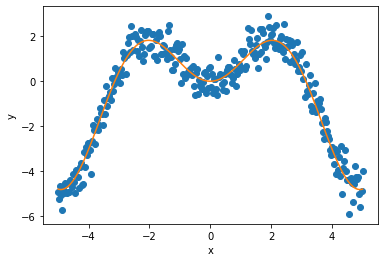

In [4]:
import matplotlib.pyplot as plt
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_mesh, color="C1")

As mentioned previously, we fit our training data with a simple
polynomial function. Here, we choose a degree equal to 10 so the function 
is able to perfectly fit $x \times \sin(x)$.

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline

degree_polyn = 10
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", LinearRegression())
    ]
)
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(
                solver="highs-ds",
                alpha=0.01,
                fit_intercept=False
        ))
    ]
)

We then estimate the prediction intervals for all the strategies very easily with a
`fit` and `predict` process. The prediction interval's lower and upper bounds
are then saved in a DataFrame. Here, we set an alpha value of 0.05
in order to obtain a 95% confidence for our prediction intervals.

In [6]:
from typing import Union, Optional
from typing_extensions import TypedDict
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.subsample import Subsample 
from sklearn.model_selection import train_test_split
Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife": Params(method="base", cv=-1),
    "jackknife_plus": Params(method="plus", cv=-1),
    "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=10),
    "cv_plus": Params(method="plus", cv=10),
    "cv_minmax": Params(method="minmax", cv=10),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=50)),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
}
y_pred, y_pis = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
        X_train, X_calib, y_train, y_calib = train_test_split(
            X_train,
            y_train,
            test_size=0.5,
            random_state=1
        )
        mapie.fit(X_train, y_train, X_calib, y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:  
        mapie = MapieRegressor(polyn_model, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.05)

Let’s now compare the confidence intervals with the predicted intervals with obtained 
by the Jackknife+, Jackknife-minmax, CV+, CV-minmax, Jackknife+-after-Boostrap, and quantile strategies. Note that for the Jackknife-after-Bootstrap method, we call the :class:`mapie.subsample.Subsample` object that allows us to train bootstrapped models.

In [7]:
def plot_1d_data(
    X_train,
    y_train, 
    X_test,
    y_test,
    y_sigma,
    y_pred, 
    y_pred_low, 
    y_pred_up,
    ax=None,
    title=None
):
    ax.set_xlabel("x") ; ax.set_ylabel("y")
    ax.fill_between(X_test, y_pred_low, y_pred_up, alpha=0.3)
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="Training data")
    ax.plot(X_test, y_test, color="gray", label="True confidence intervals")
    ax.plot(X_test, y_test - y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_test + y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_pred, color="blue", alpha=0.5, label="Prediction intervals")
    if title is not None:
        ax.set_title(title)
    ax.legend()

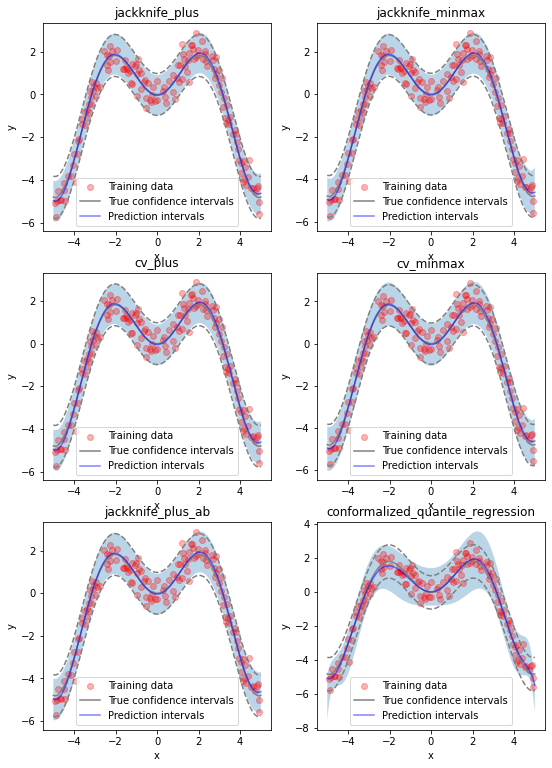

In [8]:
strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
n_figs = len(strategies)
fig, axs = plt.subplots(3, 2, figsize=(9, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
for strategy, coord in zip(strategies, coords):
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(),
        X_test.ravel(),
        y_mesh.ravel(),
        np.full((X_test.shape[0]), 1.96*noise).ravel(),
        y_pred[strategy].ravel(),
        y_pis[strategy][:, 0, 0].ravel(),
        y_pis[strategy][:, 1, 0].ravel(),
        ax=coord,
        title=strategy
    )

At first glance, the four strategies give similar results and the
prediction intervals are very close to the true confidence intervals.
Let’s confirm this by comparing the prediction interval widths over
$x$ between all strategies.

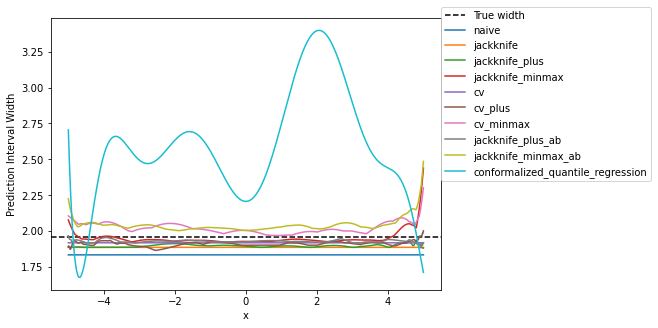

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.axhline(1.96*2*noise, ls="--", color="k", label="True width")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
_ = ax.legend(fontsize=10, loc=[1, 0.4])

As expected, the prediction intervals estimated by the Naive method
are slightly too narrow. The Jackknife, Jackknife+, CV, CV+, JaB, and J+aB give
similar widths that are very close to the true width. On the other hand,
the width estimated by Jackknife-minmax and CV-minmax are slightly too
wide. Note that the widths given by the Naive, Jackknife, and CV strategies
are constant because there is a single model used for prediction,
perturbed models are ignored at prediction time.

It's interesting to observe that quantile strategy offers more varying width,
often giving much higher but also lower interval width than other methods.

Let’s now compare the *effective* coverage, namely the fraction of test
points whose true values lie within the prediction intervals, given by
the different strategies. 

In [10]:
import pandas as pd
from mapie.metrics import regression_coverage_score
pd.DataFrame([
    [
        regression_coverage_score(
            y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]
        ),
        (
            y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0]
        ).mean()
    ] for strategy in STRATEGIES
], index=STRATEGIES, columns=["Coverage", "Width average"]).round(2)

,Coverage,Width average
naive,0.92,1.83
jackknife,0.93,1.88
jackknife_plus,0.93,1.89
jackknife_minmax,0.94,1.95
cv,0.94,1.92
cv_plus,0.93,1.91
cv_minmax,0.95,2.02
jackknife_plus_ab,0.94,1.93
jackknife_minmax_ab,0.95,2.04
conformalized_quantile_regression,0.95,2.57


All strategies except the Naive one give effective coverage close to the expected 
0.95 value (recall that alpha = 0.05), confirming the theoretical garantees.

## 2. Estimating the aleatoric uncertainty of heteroscedastic noisy data

In [11]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

In [12]:
def get_1d_data_with_heteroscedastic_noise(funct, min_x, max_x, n_samples, noise):
    """
    Generate 1D noisy data uniformely from the given function 
    and standard deviation for the noise.
    """
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples*5)
    y_train = np.array(
        [
            (funct(x) + (np.random.normal(0, noise))*x) for x in X_train
        ]
    )
    y_test = np.array(
        [
            (funct(x) + (np.random.normal(0, noise))*x) for x in X_test
        ]
    )
    y_mesh = funct(X_test)
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

We first generate noisy one-dimensional data uniformely on an interval. 
Here, the noise is considered as *heteroscedastic*, since it will change with $x$.

In [13]:
min_x, max_x, n_samples, noise = 0, 5, 300, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_heteroscedastic_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

Let's visualize our noisy function. As x increases, we the data becomes more noisy.

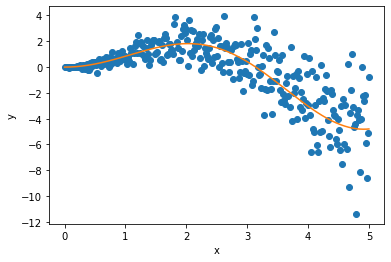

In [14]:
import matplotlib.pyplot as plt
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_mesh, color="C1")

As mentioned previously, we fit our training data with a simple
polynomial function. Here, we choose a degree equal to 10 so the function 
is able to perfectly fit $x \times \sin(x)$.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline

degree_polyn = 10
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", LinearRegression())
    ]
)
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(
                solver="highs-ds",
                alpha=0.01,
                fit_intercept=False
        ))
    ]
)

We then estimate the prediction intervals for all the strategies very easily with a
`fit` and `predict` process. The prediction interval's lower and upper bounds
are then saved in a DataFrame. Here, we set an alpha value of 0.05
in order to obtain a 95% confidence for our prediction intervals.

In [16]:
from typing import Union
from typing_extensions import TypedDict
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.subsample import Subsample 
from sklearn.model_selection import train_test_split
Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife": Params(method="base", cv=-1),
    "jackknife_plus": Params(method="plus", cv=-1),
    "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=10),
    "cv_plus": Params(method="plus", cv=10),
    "cv_minmax": Params(method="minmax", cv=10),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
}
y_pred, y_pis = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
        X_train, X_calib, y_train, y_calib = train_test_split(
            X_train,
            y_train,
            test_size=0.5,
            random_state=1
        )
        mapie.fit(X_train, y_train, X_calib, y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:  
        mapie = MapieRegressor(polyn_model, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.05)

Let’s now compare the confidence intervals with the predicted intervals with obtained 
by the Jackknife+, Jackknife-minmax, CV+, CV-minmax, Jackknife+-after-Boostrap, and quantile strategies. Note that for the Jackknife-after-Bootstrap method, we call the :class:`mapie.subsample.Subsample` object that allows us to train bootstrapped models.

In [17]:
def plot_1d_data(
    X_train,
    y_train, 
    X_test,
    y_test,
    y_sigma,
    y_pred, 
    y_pred_low, 
    y_pred_up,
    ax=None,
    title=None
):
    ax.set_xlabel("x") ; ax.set_ylabel("y")
    ax.fill_between(X_test, y_pred_low, y_pred_up, alpha=0.3)
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="Training data")
    ax.plot(X_test, y_test, color="gray", label="True confidence intervals")
    ax.plot(X_test, y_test - y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_test + y_sigma, color="gray", ls="--")
    ax.plot(X_test, y_pred, color="blue", alpha=0.5, label="Prediction intervals")
    if title is not None:
        ax.set_title(title)
    ax.legend()

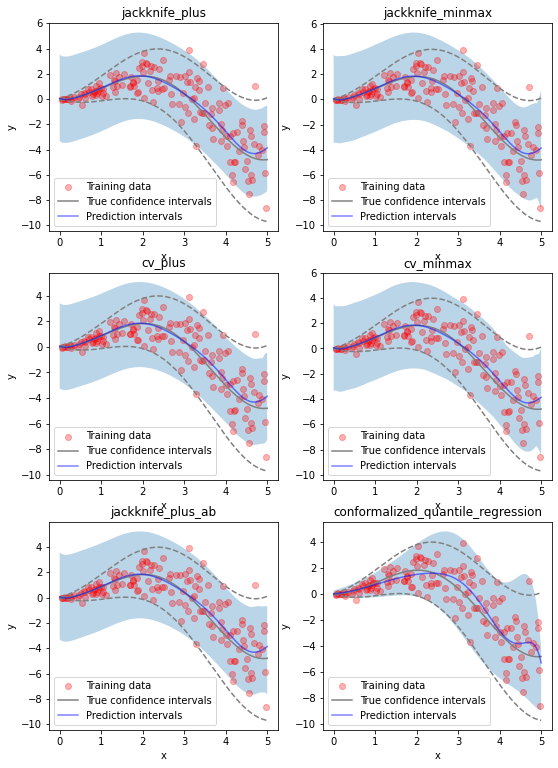

In [18]:
strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
n_figs = len(strategies)
fig, axs = plt.subplots(3, 2, figsize=(9, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
for strategy, coord in zip(strategies, coords):
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(),
        X_test.ravel(),
        y_mesh.ravel(),
        (1.96*noise*X_test).ravel(),
        y_pred[strategy].ravel(),
        y_pis[strategy][:, 0, 0].ravel(),
        y_pis[strategy][:, 1, 0].ravel(),
        ax=coord,
        title=strategy
    )

We can observe that all of the strategies seem to have similar constant prediction intervals. 
On the other hand, the quantile strategy offers a solution with prediction intervals
that are smaller when x is small and that become larger as the noise in the data grows
with heteroscedasticity.

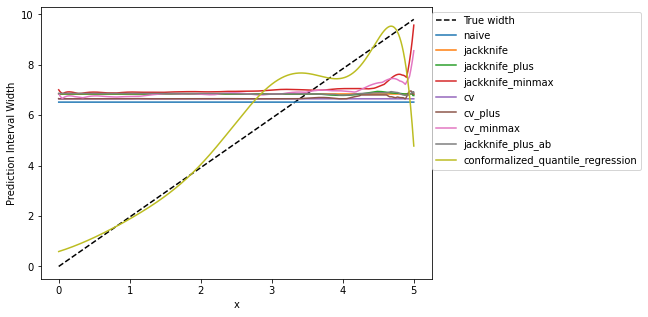

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(X_test, 1.96*2*noise*X_test, ls="--", color="k", label="True width")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
_ = ax.legend(fontsize=10, loc=[1, 0.4])

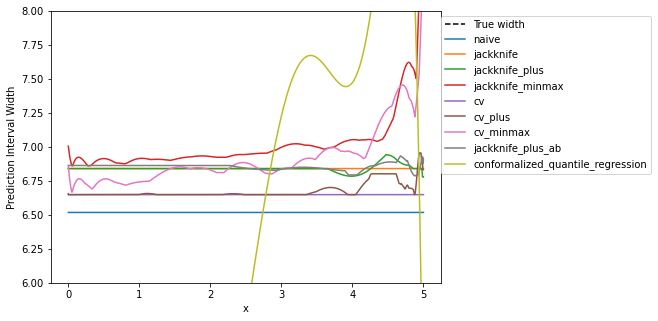

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.axhline(1.96*2*noise, ls="--", color="k", label="True width")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
ax.set_ylim(6, 8)
_ = ax.legend(fontsize=10, loc=[1, 0.4])

As we can observe all the strategies behave in a similar way as in the first example shown previously expect the quantile method which takes into account the heteroscedasticity of the data. In that method we observe very low interval widths at low values of $x$. As $x$ grows, so does the width interval and for $x > 2.75$ the interval width becomes larger for the quantile method compared to the other strategies.

Let’s now compare the *effective* coverage, namely the fraction of test
points whose true values lie within the prediction intervals, given by
the different strategies. 

In [21]:
import pandas as pd
from mapie.metrics import regression_coverage_score
pd.DataFrame([
    [
        regression_coverage_score(
            y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]
        ),
        (
            y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0]
        ).mean()
    ] for strategy in STRATEGIES
], index=STRATEGIES, columns=["Coverage", "Width average"]).round(2)

,Coverage,Width average
naive,0.94,6.52
jackknife,0.95,6.84
jackknife_plus,0.95,6.84
jackknife_minmax,0.96,7.02
cv,0.95,6.65
cv_plus,0.95,6.68
cv_minmax,0.96,6.91
jackknife_plus_ab,0.95,6.85
conformalized_quantile_regression,0.96,5.12


All strategies have the wanted coverage, however, we notice that the quantile strategy has much lower coverage than all other methods.

## 3. Estimating the epistemic uncertainty of out-of-distribution data

Let’s now consider one-dimensional data without noise, but normally distributed.
The goal is to explore how the prediction intervals evolve for new data 
that lie outside the distribution of the training data in order to see how the strategies
can capture the *epistemic* uncertainty. 
For a comparison of the epistemic and aleatoric uncertainties, please have a look at this
[source](https://en.wikipedia.org/wiki/Uncertainty_quantification).

Lets" start by generating and showing the data. 

In [22]:
def get_1d_data_with_normal_distrib(funct, mu, sigma, n_samples, noise):
    """
    Generate noisy 1D data with normal distribution from given function 
    and noise standard deviation.
    """
    np.random.seed(59)
    X_train = np.random.normal(mu, sigma, n_samples)
    X_test = np.arange(mu-4*sigma, mu+4*sigma, sigma/20.)
    y_train, y_mesh, y_test = funct(X_train), funct(X_test), funct(X_test)
    y_train += np.random.normal(0, noise, y_train.shape[0])
    y_test += np.random.normal(0, noise, y_test.shape[0])
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

In [23]:
mu = 0 ; sigma = 2 ; n_samples = 600 ; noise = 0.
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_normal_distrib(
    x_sinx, mu, sigma, n_samples, noise
)

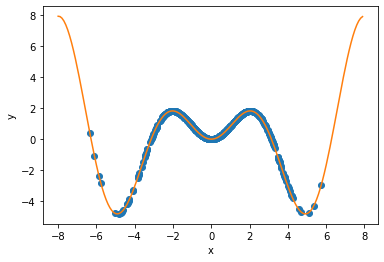

In [24]:
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_test, color="C1")

As before, we estimate the prediction intervals using a polynomial
function of degree 10 and show the results for the Jackknife+ and CV+
strategies.

In [25]:
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(
                solver="highs-ipm",
                alpha=0.09,
                fit_intercept=True
        ))
    ]
)
Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife": Params(method="base", cv=-1),
    "jackknife_plus": Params(method="plus", cv=-1),
    "jackknife_minmax": Params(method="minmax", cv=-1),
    "cv": Params(method="base", cv=10),
    "cv_plus": Params(method="plus", cv=10),
    "cv_minmax": Params(method="minmax", cv=10),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    "jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=50)),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
}
y_pred, y_pis = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
        X_train, X_calib, y_train, y_calib = train_test_split(
            X_train,
            y_train,
            test_size=0.5,
            random_state=1
        )
        mapie.fit(X_train, y_train, X_calib, y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:  
        mapie = MapieRegressor(polyn_model, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.05)

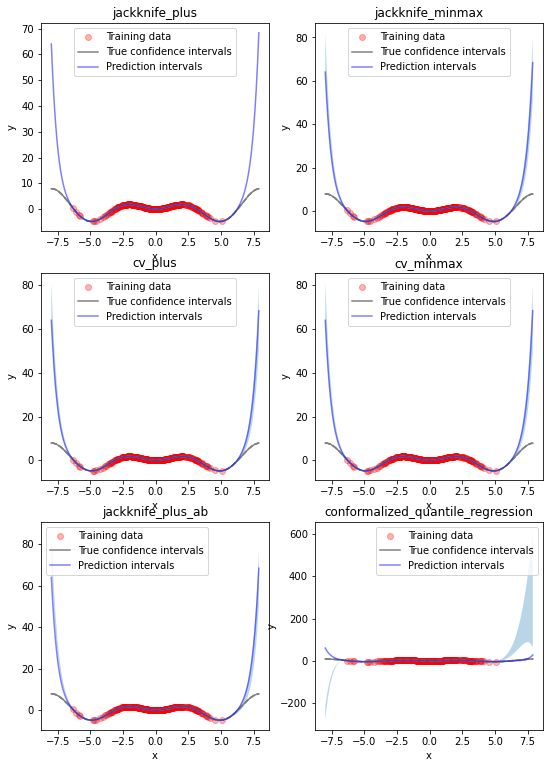

In [26]:
strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
n_figs = len(strategies)
fig, axs = plt.subplots(3, 2, figsize=(9, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
for strategy, coord in zip(strategies, coords): 
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(), 
        X_test.ravel(),
        y_mesh.ravel(),
        1.96*noise, 
        y_pred[strategy].ravel(),
        y_pis[strategy][:, 0, :].ravel(),
        y_pis[strategy][:, 1, :].ravel(), 
        ax=coord,
        title=strategy
    )

At first glance, our polynomial function does not give accurate
predictions with respect to the true function when $|x > 6|$. 
The prediction intervals estimated with the Jackknife+ do not seem to 
increase significantly, unlike the CV+ method whose prediction intervals
capture a high uncertainty when $x > 6$.

Let's now compare the prediction interval widths between all strategies. 


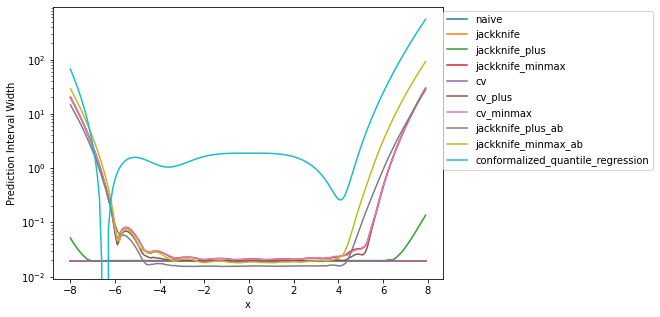

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_yscale("log")
for strategy in STRATEGIES:
    ax.plot(X_test, y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0], label=strategy)
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
ax.legend(fontsize=10, loc=[1, 0.4]);

The prediction interval widths start to increase exponentially
for $|x| > 4$ for the CV+, CV-minmax, Jackknife-minmax, and quantile
strategies. On the other hand, the prediction intervals estimated by
Jackknife+ remain roughly constant until $|x| \sim 5$ before
increasing.
Note that the quantile strategy has notably higher interval width throughout
the values of x, except for a sudden drop at $x = -6.5$.

In [28]:
pd.DataFrame([
    [
        regression_coverage_score(
            y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]
        ),
        (
            y_pis[strategy][:, 1, 0] - y_pis[strategy][:, 0, 0]
        ).mean()
    ] for strategy in STRATEGIES
], index=STRATEGIES, columns=["Coverage", "Width average"]).round(3)

,Coverage,Width average
naive,0.562,0.019
jackknife,0.575,0.020
jackknife_plus,0.569,0.024
jackknife_minmax,0.675,1.768
cv,0.575,0.020
cv_plus,0.650,1.772
cv_minmax,0.681,1.778
jackknife_plus_ab,0.688,1.648
jackknife_minmax_ab,0.806,4.810
conformalized_quantile_regression,0.581,26.631


In conclusion, the Jackknife-minmax, CV+, CV-minmax, or Jackknife-minmax-ab strategies are more
conservative than the Jackknife+ strategy, and tend to result in more
reliable coverages for *out-of-distribution* data. It is therefore
advised to use the three former strategies for predictions with new
out-of-distribution data.
Note however that there are no theoretical guarantees on the coverage level 
for out-of-distribution data.
Here it's important to note that the quantile method most likely has negative values (at $x = -6.5$) of width thereby giving a low average width. This can be due to its inherit structure, it is possible that the prediction values for quantile 0.025 can be greater than that of 0.975 points where a lot of uncertainty lies.

## 4. Estimating the uncertainty with different sklearn-compatible regressors

MAPIE can be used with any kind of sklearn-compatible regressor. Here, we
illustrate this by comparing the prediction intervals estimated by the CV+ method using
different models:

- the same polynomial function as before.
 
- a XGBoost model using the Scikit-learn API.

- a simple neural network, a Multilayer Perceptron with three dense layers, using the KerasRegressor wrapper.

Once again, let’s use our noisy one-dimensional data obtained from a
uniform distribution.

In [29]:
min_x, max_x, n_samples, noise = -5, 5, 100, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

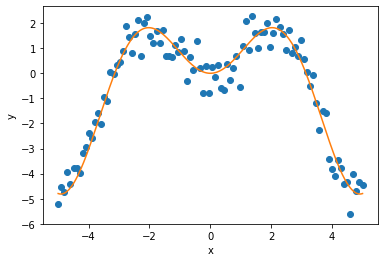

In [30]:
plt.xlabel("x") ; plt.ylabel("y")
plt.plot(X_test, y_mesh, color="C1")
_ = plt.scatter(X_train, y_train)

Let's then define the models. The boosing model considers 100 shallow trees with a max depth of 2 while
the Multilayer Perceptron has two hidden dense layers with 20 neurons each followed by a relu activation.


In [31]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # disable debugging logs from Tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
def mlp():
    """
    Two-layer MLP model
    """
    model = Sequential([
        Dense(units=20, input_shape=(1,), activation="relu"),
        Dense(units=20, activation="relu"),
        Dense(units=1)
    ])
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [32]:
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", LinearRegression(fit_intercept=False))
    ]
)

In [33]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    max_depth=2,
    n_estimators=100,
    tree_method="hist",
    random_state=59,
    learning_rate=0.1,
    verbosity=0,
    nthread=-1
)
mlp_model = KerasRegressor(
    build_fn=mlp, 
    epochs=500, 
    verbose=0
)

Let's now use MAPIE to estimate the prediction intervals using the CV+ method 
and compare their prediction interval.

In [34]:
models = [polyn_model, xgb_model, mlp_model]
model_names = ["polyn", "xgb", "mlp"]
prediction_interval = {}
for name, model in zip(model_names, models):
    mapie = MapieRegressor(model, method="plus", cv=5)
    mapie.fit(X_train, y_train)
    y_pred[name], y_pis[name] = mapie.predict(X_test, alpha=0.05)

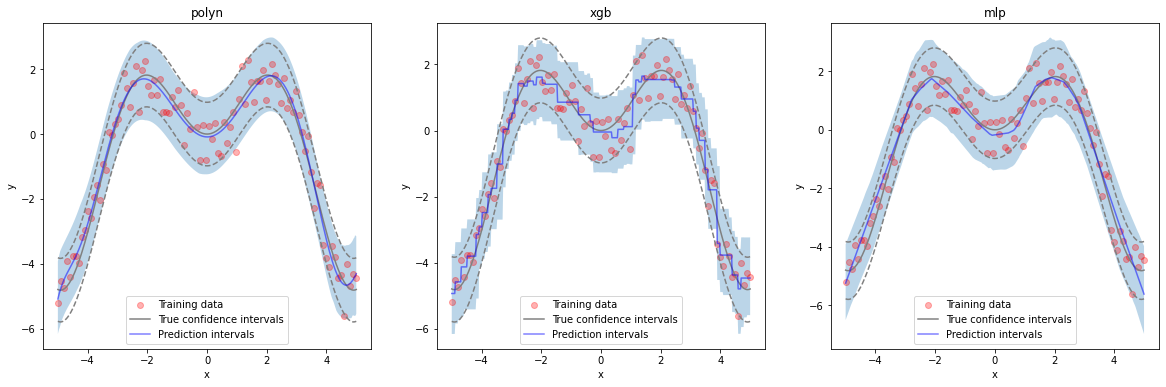

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
for name, ax in zip(model_names, axs):
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(),
        X_test.ravel(),
        y_mesh.ravel(),
        1.96*noise,
        y_pred[name].ravel(),
        y_pis[name][:, 0, 0].ravel(),
        y_pis[name][:, 1, 0].ravel(),
        ax=ax,
        title=name
    )

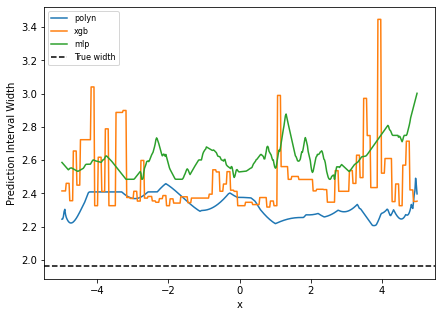

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for name in model_names:
    ax.plot(X_test, y_pis[name][:, 1, 0] - y_pis[name][:, 0, 0])
ax.axhline(1.96*2*noise, ls="--", color="k")
ax.set_xlabel("x")
ax.set_ylabel("Prediction Interval Width")
ax.legend(model_names + ["True width"], fontsize=8);

As expected with the CV+ method, the prediction intervals are a bit 
conservative since they are slightly wider than the true intervals.
However, the CV+ method on the three models gives very promising results 
since the prediction intervals closely follow the true intervals with $x$. 